In [66]:
from skimage import color, io, measure, img_as_ubyte, util, data, morphology
from skimage.measure import profile_line, label, regionprops
from skimage.transform import rescale, resize, rotate, matrix_transform, SimilarityTransform, EuclideanTransform, warp, swirl
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.decomposition import PCA
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, label2rgb
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v, prewitt, median
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening, square
from skimage.segmentation import clear_border
from scipy.stats import norm
from scipy.spatial import distance
import scipy.io as sio
import glob
import os
import SimpleITK as sitk
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import correlate

In [40]:
# Load the data
iris_data = np.loadtxt("irisdata.txt", comments="%")

# Standardize the data
mn = np.mean(iris_data, axis=0)
data = iris_data - mn

# Perform PCA
pca = PCA(n_components=2)  # We are only interested in the first two components for now
pca.fit(data)

# Extract the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = explained_variance_ratio.sum() * 100  # convert to percentage
# Project the data into PCA space
iris_data_pca = pca.transform(data)

# Extract the projected values for the first flower
first_flower_pca = iris_data_pca[0]

# Print the projected values of the first flower
print(f"Projected values of the first flower in PCA space: {first_flower_pca}")
# Print the results

print(f"Total variance explained by the first two principal components: {total_explained_variance:.2f}%")

Projected values of the first flower in PCA space: [-2.86541481  0.29629459]
Total variance explained by the first two principal components: 97.08%


In [41]:
img = io.imread('sky_gray.png')

# Convert image to floating point for precision in transformation
img = img_as_float(img)

# Original min and max
orig_min, orig_max = img.min(), img.max()

# New min and max
new_min, new_max = 10, 200

# Apply histogram stretching
img_stretched = new_min + (img - orig_min) * (new_max - new_min) / (orig_max - orig_min)

# Convert to appropriate data type
img_stretched = img_stretched.astype(np.uint8)

# Calculate the average pixel value
average_pixel_value = img_stretched.mean()

print(f"Average pixel value of the new image: {average_pixel_value}")

Average pixel value of the new image: 86.53926595052083


Number of foreground pixels in the final image: 19613


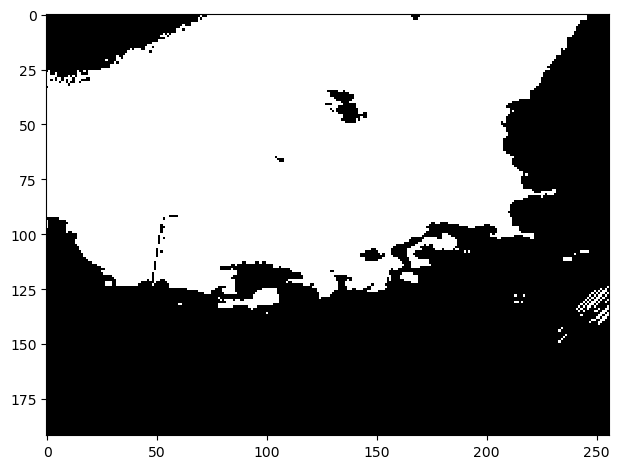

In [55]:
# Load the image
img = io.imread('sky.png')

# Apply the RGB thresholds
foreground_mask = (img[:,:,0] < 100) & (img[:,:,1] > 85) & (img[:,:,1] < 200) & (img[:,:,2] > 150)
io.imshow(foreground_mask)

# Create a disk-shaped structuring element with radius=5
selem = disk(5)

# Perform erosion, setting border pixels to 1
eroded_mask =erosion(foreground_mask, footprint=selem)

# Count the number of foreground pixels in the eroded image
foreground_pixels = np.sum(eroded_mask)


print(f"Number of foreground pixels in the final image: {foreground_pixels}")

The number of foreground pixels in the final image is: 4948


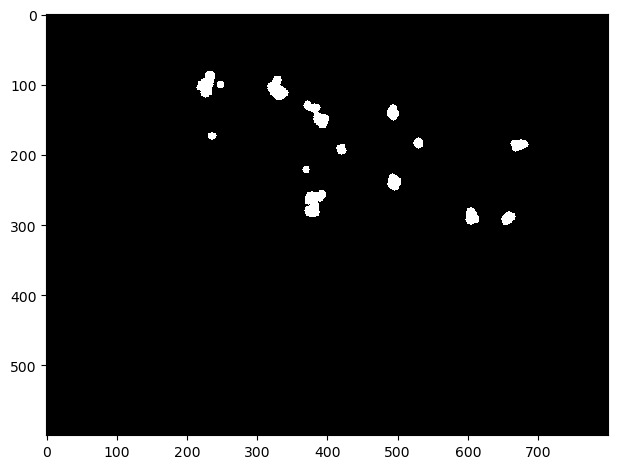

In [43]:
# Load the image
img = io.imread('flower.png')

# Convert from RGB to HSV
img_hsv = color.rgb2hsv(img)

# Apply HSV threshold
foreground_mask = (img_hsv[:,:,0] < 0.25) & (img_hsv[:,:,1] > 0.8) & (img_hsv[:,:,2] > 0.8)
io.imshow(foreground_mask)
# Morphological opening (erosion followed by dilation)
selem =disk(5)
opened_mask = opening(foreground_mask, selem)
io.imshow(opened_mask)
# Calculate the number of foreground pixels
foreground_pixels = np.sum(opened_mask)

print(f"The number of foreground pixels in the final image is: {foreground_pixels}")

In [44]:
# Prepare a list for the data matrix
data_matrix = []

# Load and process each image
for i in range(1, 6):
    # Load the image
    img = io.imread(f'car{i}.jpg')
    
    # # Check if the image has 3 dimensions (i.e., color image)
    # if len(img.shape) == 3 and img.shape[2] == 3:
    #     # Convert to grayscale
    #     gray_img = color.rgb2gray(img)
    # elif len(img.shape) == 2:
    #     # Image is already in grayscale
    #     gray_img = img
    # else:
    #     raise ValueError("The image format is not supported.")
    
    # Flatten the grayscale image to create a 1D array
    flat_gray = img.flatten()
    
    # Append the flattened image to the data matrix
    data_matrix.append(flat_gray)

# Convert the list to a NumPy array
data_matrix = np.array(data_matrix)

# Perform PCA
pca = PCA(n_components=5)  # We use 5 because we have 5 images
pca.fit(data_matrix)

# Print the percentage of variance explained by the first principal component
print(f"Percentage of variance explained by the first principal component: {pca.explained_variance_ratio_[0] * 100:.2f}%")

Percentage of variance explained by the first principal component: 40.13%


In [50]:
# Load the grayscale image
img = io.imread('sky_gray.png', as_gray=True)

# Convert image to float for processing
img_float = img_as_float(img)

# Apply gamma correction
gamma = 1.21
gamma_corrected = np.power(img_float, gamma)

# Apply a 5x5 median filter
filtered_img = median(gamma_corrected, footprint=square(5))

img = img_as_ubyte(filtered_img)
# Retrieve the pixel value at row=40, column=50 (converted to 0-based index)
pixel_value = img[39, 49]  # Converting from 1-based to 0-based index

print(f"The pixel value at row=40, column=50 is: {pixel_value:.4f}")

The pixel value at row=40, column=50 is: 68.0000


In [51]:
# Load the image
input_img = io.imread('flowerwall.png', as_gray=True)

# Convert image to float for processing
input_img = img_as_float(input_img)

# Create the averaging filter
filter_size = 15
weights = np.ones((filter_size, filter_size)) / (filter_size * filter_size)

# Apply the averaging filter with border replication using reflect mode
res_img_refl = correlate(input_img, weights, mode="reflect")

# Retrieve the pixel value at row=5, column=50 (converting from 1-based to 0-based indexing)
pixel_value = res_img_refl[4, 49]*255  # Convert 1-based index to 0-based

print(f"The pixel value at row=5, column=50 is: {pixel_value:.4f}")

The pixel value at row=5, column=50 is: 208.5511


In [74]:
image_path = 'floorboards.png'
image = io.imread(image_path, as_gray=True)
image = img_as_ubyte(image)  # Convert to an 8-bit image

# Apply threshold
threshold_value = 100
binary_image = image < threshold_value

# Perform morphological closing
struct_elem = disk(10)
closed_image = binary_closing(binary_image, struct_elem)

# Perform morphological opening
struct_elem_small = disk(3)
opened_image = binary_opening(closed_image, struct_elem_small)

# Remove blobs connected to the image border
clean_image = clear_border(opened_image)
# Label the image to find connected components
label_image = label(clean_image, connectivity=2)  # Use 8-connectivity

region_props = measure.regionprops(label_image)
areas = np.array([prop.area for prop in region_props])
blobs_count = areas[areas > 100]

print(f'Number of BLOBs with area > 100 pixels: {len(blobs_count)}')

# Count the foreground pixels
foreground_pixels = np.sum(clean_image)

print(f'Number of foreground pixels remaining: {foreground_pixels}')

Number of BLOBs with area > 100 pixels: 16
Number of foreground pixels remaining: 6491


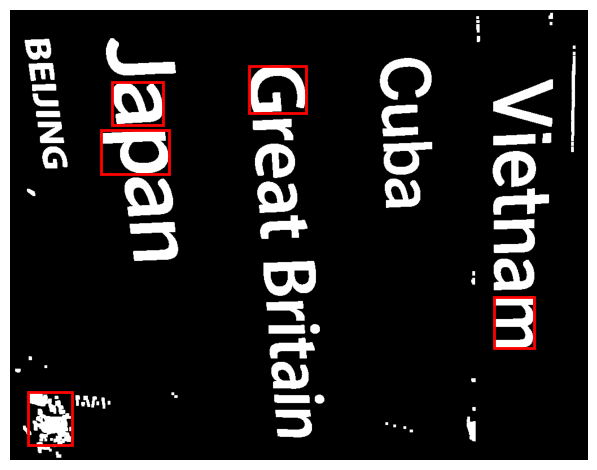

Number of visible letters: 5


In [83]:
import matplotlib.pyplot as plt
# Load the image
image = io.imread("books_bw.png")

# Label the image regions
label_image = label(binary_image, connectivity=2)  # 8-connectivity

# Calculate region properties
props = regionprops(label_image)

# Filter regions based on area and perimeter
filtered_regions = [prop for prop in props if prop.area > 100 and prop.perimeter > 500]

# Plot results
fig, ax = plt.subplots()
ax.imshow(binary_image, cmap='gray')

for region in filtered_regions:
    # Draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                        fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

print(f"Number of visible letters: {len(filtered_regions)}")

In [100]:
fixed_points = sio.loadmat('catfixedPoints.mat')
moving_points = sio.loadmat('catmovingPoints.mat')
# Access the data
fixed_points_data = np.array(fixed_points['fixedpoints'])
moving_points_data = np.array(moving_points['movingpoints'])

print(fixed_points_data.shape)
print(moving_points_data.shape)
ssd = np.sum((fixed_points_data - moving_points_data) ** 2)

print(f"Sum of Squared Differences between the fixed and moving landmarks: {ssd}")

(7, 2)
(7, 2)
Sum of Squared Differences between the fixed and moving landmarks: 46552.968750000015


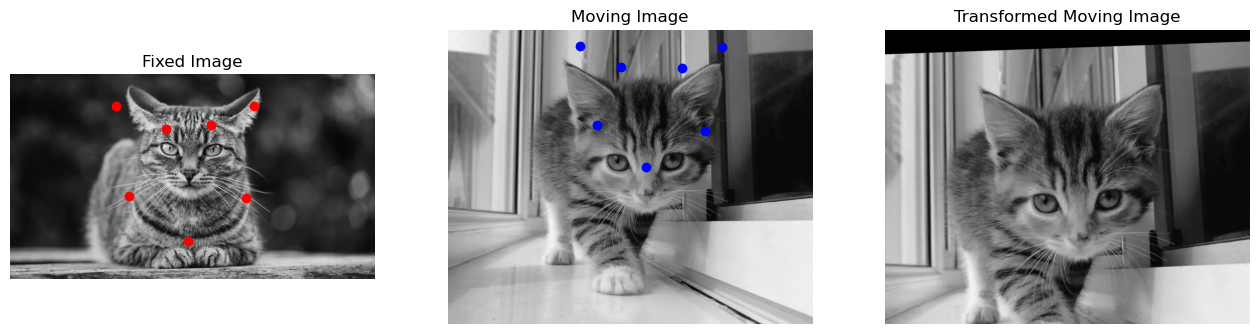

In [117]:
from skimage import io, transform

# Load the images
img_fixed = io.imread('cat1.png')
img_moving = io.imread('cat2.png')


tform = SimilarityTransform()
tform.estimate(moving_points_data, fixed_points_data)
warped = warp(img_moving, tform.inverse)
# Compute the similarity transform
# tform = transform.estimate_transform('similarity', moving_points_data, fixed_points_data)

# Apply the transformation to the moving image
# transformed_image = transform.warp(img_moving, inverse_map=tform.inverse, output_shape=img_fixed.shape)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes[0].imshow(img_fixed, cmap='gray')
axes[0].plot(fixed_points_data[:, 0], fixed_points_data[:, 1], 'ro')
axes[0].set_title('Fixed Image')
axes[1].imshow(img_moving, cmap='gray')
axes[1].plot(moving_points_data[:, 0], moving_points_data[:, 1], 'bo')
axes[1].set_title('Moving Image')
axes[2].imshow(warped, cmap='gray')
axes[2].set_title('Transformed Moving Image')
for ax in axes:
    ax.axis('off')
plt.show()


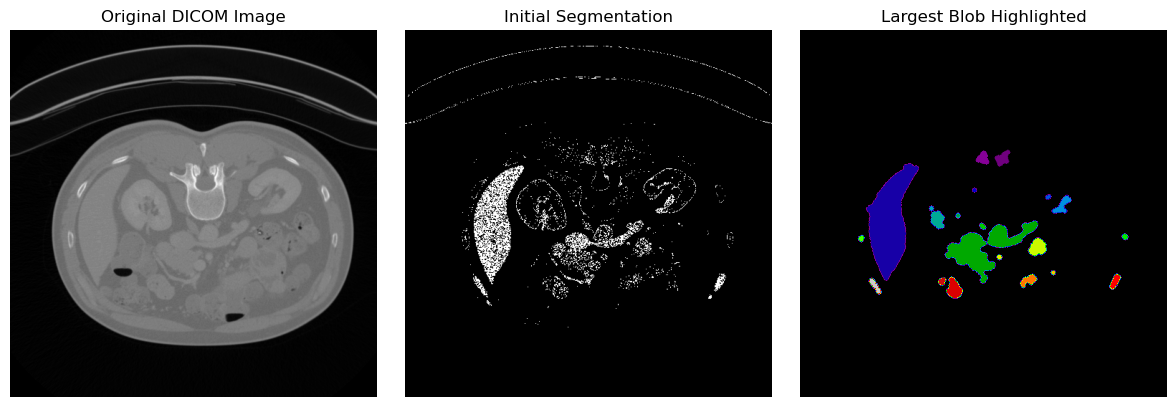

Area of the largest BLOB: 5982.0 pixels


In [130]:
# Load the DICOM file
dicom_path = '1-179.dcm'
dicom_image = dicom.dcmread(dicom_path).pixel_array

mask_path = 'LiverROI.png'
liver_mask = io.imread(mask_path)
# Use the whole DICOM image to calculate average and std dev instead of just liver region
# If you're just using the liver region, you can skip these lines and use your previous liver_pixel_values
all_pixel_values = dicom_image[liver_mask > 0]  # Exclude background if necessary
average_value = np.mean(all_pixel_values)
std_deviation = np.std(all_pixel_values)

# Calculate thresholds
T1 = average_value - std_deviation
T2 = average_value + std_deviation

# Create a binary segmentation based on the thresholds
segmentation = (dicom_image > T1) & (dicom_image < T2)

# Count the number of foreground pixels
foreground_pixels_count = np.sum(segmentation)

# Create structuring element
selem = disk(3)

# Apply morphological closing
closed = binary_closing(segmentation, selem)

# Apply morphological opening
opened = binary_opening(closed, selem)

# Perform BLOB analysis using 8-connectivity
label_image = label(opened, connectivity=2)  # Use 8-connectivity

# Measure properties of labeled regions
props = measure.regionprops(label_image)

# Find the largest BLOB by area
largest_blob_area = max(prop.area for prop in props if prop.area)

# Plotting the original and processed images for visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(dicom_image, cmap='gray')
ax[0].set_title('Original DICOM Image')
ax[0].axis('off')

ax[1].imshow(segmentation, cmap='gray')
ax[1].set_title('Initial Segmentation')
ax[1].axis('off')

ax[2].imshow(label_image, cmap='nipy_spectral')
ax[2].set_title('Largest Blob Highlighted')
ax[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Area of the largest BLOB: {largest_blob_area} pixels')

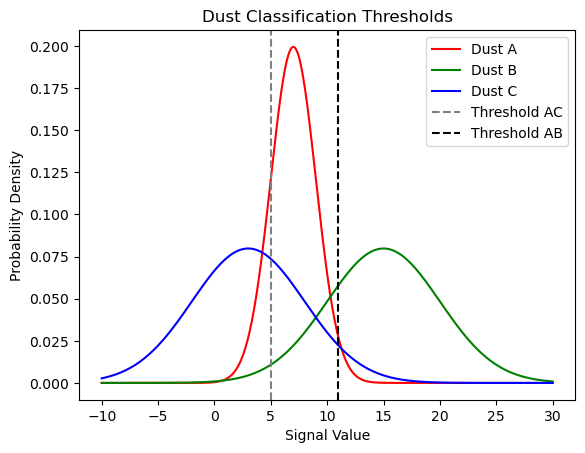

In [131]:
# Means and standard deviations
means = np.array([7, 15, 3])
stddevs = np.array([2, 5, 5])

# Create a range of x values
x = np.linspace(-10, 30, 400)

# Plotting the distributions
colors = ['red', 'green', 'blue']
labels = ['Dust A', 'Dust B', 'Dust C']
for mean, stddev, color, label in zip(means, stddevs, colors, labels):
    plt.plot(x, norm.pdf(x, mean, stddev), color=color, label=label)

# Add threshold lines
plt.axvline(x=5, color='gray', linestyle='--', label='Threshold AC')
plt.axvline(x=11, color='black', linestyle='--', label='Threshold AB')

plt.legend()
plt.title('Dust Classification Thresholds')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.show()

Threshold between A and B: 10.30
Threshold between A and C: 4.25
Threshold between B and C: 9.00


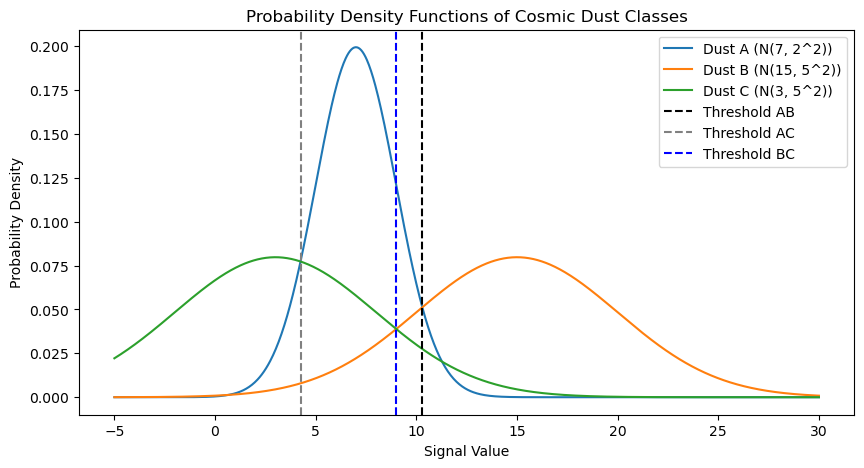

In [133]:
from scipy.optimize import fsolve
# Define the ranges and means and standard deviations
x = np.linspace(-5, 30, 1000)
mean_A, std_A = 7, 2
mean_B, std_B = 15, 5
mean_C, std_C = 3, 5

# Calculate the PDFs
pdf_A = norm.pdf(x, mean_A, std_A)
pdf_B = norm.pdf(x, mean_B, std_B)
pdf_C = norm.pdf(x, mean_C, std_C)

# Plot the PDFs
plt.figure(figsize=(10, 5))
plt.plot(x, pdf_A, label='Dust A (N(7, 2^2))')
plt.plot(x, pdf_B, label='Dust B (N(15, 5^2))')
plt.plot(x, pdf_C, label='Dust C (N(3, 5^2))')
plt.title('Probability Density Functions of Cosmic Dust Classes')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.legend()

# Function to find intersections
def find_intersection(mean1, std1, mean2, std2):
    # Define the equation to solve
    def equation(x):
        return norm.pdf(x, mean1, std1) - norm.pdf(x, mean2, std2)
    # Initial guess is halfway between means
    initial_guess = (mean1 + mean2) / 2
    return fsolve(equation, x0=initial_guess)[0]

# Calculate intersections
threshold_AB = find_intersection(mean_A, std_A, mean_B, std_B)
threshold_AC = find_intersection(mean_A, std_A, mean_C, std_C)
threshold_BC = find_intersection(mean_B, std_B, mean_C, std_C)

# Print thresholds
print(f'Threshold between A and B: {threshold_AB:.2f}')
print(f'Threshold between A and C: {threshold_AC:.2f}')
print(f'Threshold between B and C: {threshold_BC:.2f}')

# Add lines for thresholds
plt.axvline(threshold_AB, color='black', linestyle='--', label='Threshold AB')
plt.axvline(threshold_AC, color='grey', linestyle='--', label='Threshold AC')
plt.axvline(threshold_BC, color='blue', linestyle='--', label='Threshold BC')
plt.legend()
plt.show()

In [141]:
from numpy.linalg import norm
image = np.array([[167,193,180],
                  [9,189,8],
                  [217,100,71]])

template = np.array([
    [208, 233, 71],
    [231, 161, 139],
    [32, 25, 244]
])


# Compute NCC
def compute_ncc(template, image_patch):
    template_flat = template.flatten()
    image_patch_flat = image_patch.flatten()
    
    # Dot product between flattened template and image patch
    dot_product = np.dot(template_flat, image_patch_flat)
    
    # Norms of the vectors
    norm_template = norm(template_flat)
    norm_image_patch = norm(image_patch_flat)
    
    # Normalized Cross Correlation
    ncc = dot_product / (norm_template * norm_image_patch)
    return ncc

ncc_value = compute_ncc(template, image)
print("Normalized Cross Correlation (NCC):", ncc_value)

Normalized Cross Correlation (NCC): 0.6749205114127521


In [142]:
focal_length = 0.01  # in meters
object_distance = 1.1  # in meters
object_size = 0.4  # in meters (40 cm)

# Sensor specifications
sensor_width_mm = 5.4  # in mm
resolution_width = 6480  # in pixels

# Step 1: Calculate image scale
scale = focal_length / object_distance

# Step 2: Calculate image size on the sensor in meters
image_length_m = object_size * scale

# Convert image length from meters to millimeters
image_length_mm = image_length_m * 1000  # 1 m = 1000 mm

# Step 3: Calculate pixels per mm
pixels_per_mm = resolution_width / sensor_width_mm

# Calculate the image size in pixels
fish_image_pixels = image_length_mm * pixels_per_mm

print(f"The fish will be approximately {fish_image_pixels:.2f} pixels wide.")

The fish will be approximately 4363.64 pixels wide.


In [144]:
def LDA(X, y):
    n, m = X.shape
    class_label = np.unique(y)
    k = len(class_label)
    n_group = np.zeros((k,1))
    group_mean = np.zeros((k,m))
    pooled_cov = np.zeros((m,m))
    W = np.zeros((k,m+1))
    
    for i in range(k):
        group = np.squeeze(y == class_label[i])
        n_group[i] = np.sum(group.astype(np.double))
        group_mean[i,:] = np.mean(X[group,:], axis=0)
        pooled_cov += ((n_group[i] - 1) / (n - k)) * np.cov(X[group,:], rowvar=False)
    
    pooled_cov_inv = np.linalg.inv(pooled_cov)
    prior_prob = n_group / n
    
    for i in range(k):
        temp = group_mean[i,:][np.newaxis] @ pooled_cov_inv
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        W[i,1:] = temp
    
    return W

# Training data
X = np.array([
    [1.00, 1.00], [2.20, -3.00], [3.50, -1.40], [3.70, -2.70], [5.00, 0],
    [0.10, 0.70], [0.22, -2.10], [0.35, -0.98], [0.37, -1.89], [0.50, 0]
])
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# Train the LDA model
W = LDA(X, y)

# Compute scores for the test example (1.00, 1.00)
test_example = np.array([[1, 1.00, 1.00]])  # Including bias term
scores = test_example.dot(W.T)

# Compute the probability using the softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

probability = softmax(scores)
print(f"The probability that the point (1.00, 1.00) belongs to class 1 is {probability[0][1]:.2f}")

The probability that the point (1.00, 1.00) belongs to class 1 is 0.81
